In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('stroke_risk_dataset.csv')
print(data.head())
print(data.info())
print(data.describe())

   Chest Pain  Shortness of Breath  Irregular Heartbeat  Fatigue & Weakness  \
0           0                    1                    1                   1   
1           0                    0                    1                   0   
2           1                    0                    0                   1   
3           1                    0                    1                   1   
4           0                    0                    1                   0   

   Dizziness  Swelling (Edema)  Pain in Neck/Jaw/Shoulder/Back  \
0          0                 0                               0   
1          0                 1                               0   
2          1                 1                               0   
3          0                 1                               1   
4          0                 1                               0   

   Excessive Sweating  Persistent Cough  Nausea/Vomiting  High Blood Pressure  \
0                   1                 1        

In [3]:
print(data.isnull().sum())

Chest Pain                        0
Shortness of Breath               0
Irregular Heartbeat               0
Fatigue & Weakness                0
Dizziness                         0
Swelling (Edema)                  0
Pain in Neck/Jaw/Shoulder/Back    0
Excessive Sweating                0
Persistent Cough                  0
Nausea/Vomiting                   0
High Blood Pressure               0
Chest Discomfort (Activity)       0
Cold Hands/Feet                   0
Snoring/Sleep Apnea               0
Anxiety/Feeling of Doom           0
Age                               0
Stroke Risk (%)                   0
At Risk (Binary)                  0
dtype: int64


In [4]:
y = data['At Risk (Binary)']
X = data.drop(['At Risk (Binary)', 'Stroke Risk (%)'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
numerical_features = ['Age']
binary_features = [col for col in X.columns if col not in numerical_features]
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [8]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [9]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))])

In [10]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall_macro',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['Chest '
                                                                          'Pain',
                                                                          'Shortness '
                                                                          'of '
                                                                          'Breath',
                                                                          'Irregular '...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall_macro')

In [11]:
print("Best Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score (Recall): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Best Hyperparameters found by GridSearchCV:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200}

Best cross-validation score (Recall): 0.9417



Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      4911
           1       0.97      0.95      0.96      9089

    accuracy                           0.95     14000
   macro avg       0.94      0.95      0.94     14000
weighted avg       0.95      0.95      0.95     14000

Plotting RandomForest Confusion Matrix...


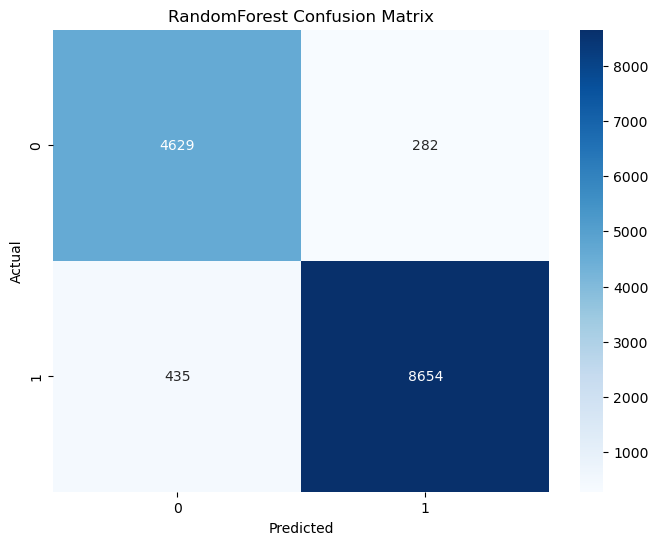

In [12]:
y_pred = best_model.predict(X_test)


print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


print("Plotting RandomForest Confusion Matrix...")
cm_rf = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('RandomForest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [13]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.7, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='recall_macro',
    cv=3,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train_encoded)

print(f"Best cross-validation score (recall_macro): {grid_search_xgb.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")

Best cross-validation score (recall_macro): 0.9931
Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4911
           1       0.99      1.00      1.00      9089

    accuracy                           1.00     14000
   macro avg       1.00      0.99      1.00     14000
weighted avg       1.00      1.00      1.00     14000

Plotting XGBoost Confusion Matrix...


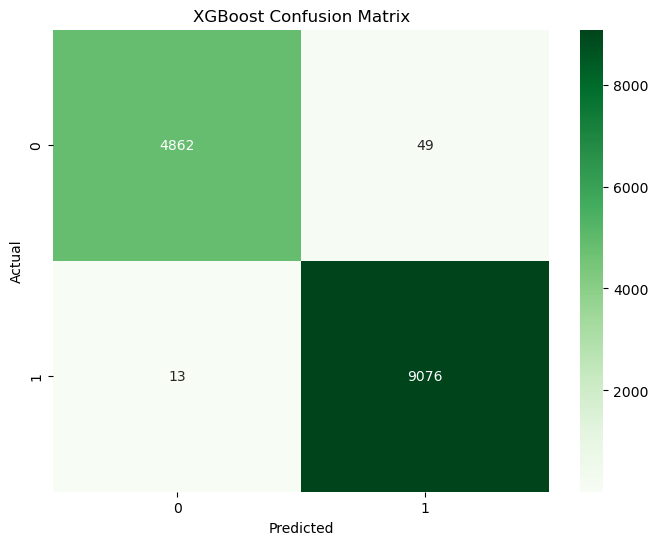

In [14]:
y_pred_xgb_encoded = grid_search_xgb.best_estimator_.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

print(classification_report(y_test, y_pred_xgb))

print("Plotting XGBoost Confusion Matrix...")
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Ultimately, my prior dataset was no good. It had too many null values, and it wasn't a great dataset to work on. I fumbled around with it for a long time before deciding to go with a different dataset. This one is much simpler, with binary values for all the categories, and the model with few changes yields much more accurate results. I only needed to modify the features list and the axis names for plotting. Unfortunately, I ended up removing a lot of the cleaning and preprocessing I had written for the prior dataset, but no amount of cleaning could take care of that piece of work. Given more time, I'd find a slightly messier dataset to demonstrate more cleaning and preprocessing abilities, but with a functioning and accurate model, I can happily help predict strokes before they occur.

